In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import json
import cv2
import numpy as np
from PIL import Image
import pycocotools.mask as maskUtils

from matting_api import Matting

sys.path.append('..')
import utils
import inference as infer
from datasets import COCOADataset, read_COCOA
from demo_utils import *

font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [4]:
def read_annot(fn, h, w):
    with open(fn, 'r') as f:
        ann = json.load(f)
    ret_modal, ret_bboxes, ret_category, ret_amodal = [], [], [], []
    for reg in ann['regions']:
        modal, bbox, category = read_COCOA(reg, h, w)
        ret_modal.append(modal)
        ret_bboxes.append(bbox)
        ret_category.append(category)
        amodal = maskUtils.decode(maskUtils.merge(
            maskUtils.frPyObjects([reg['segmentation']], h, w)))
        ret_amodal.append(amodal)
    return np.array(ret_modal), np.array(ret_category), np.array(ret_bboxes), np.array(ret_amodal)

In [2]:
# please skip this cell if you don't want to download the dataset.
phase = 'val'
root_dict = {'train': "../data/COCOA/train2014", 'val': "../data/COCOA/val2014"}

img_root = root_dict[phase]
annot_path = "../data/COCOA/annotations/COCO_amodal_{}2014.json".format(phase)

data_reader = COCOADataset(annot_path)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


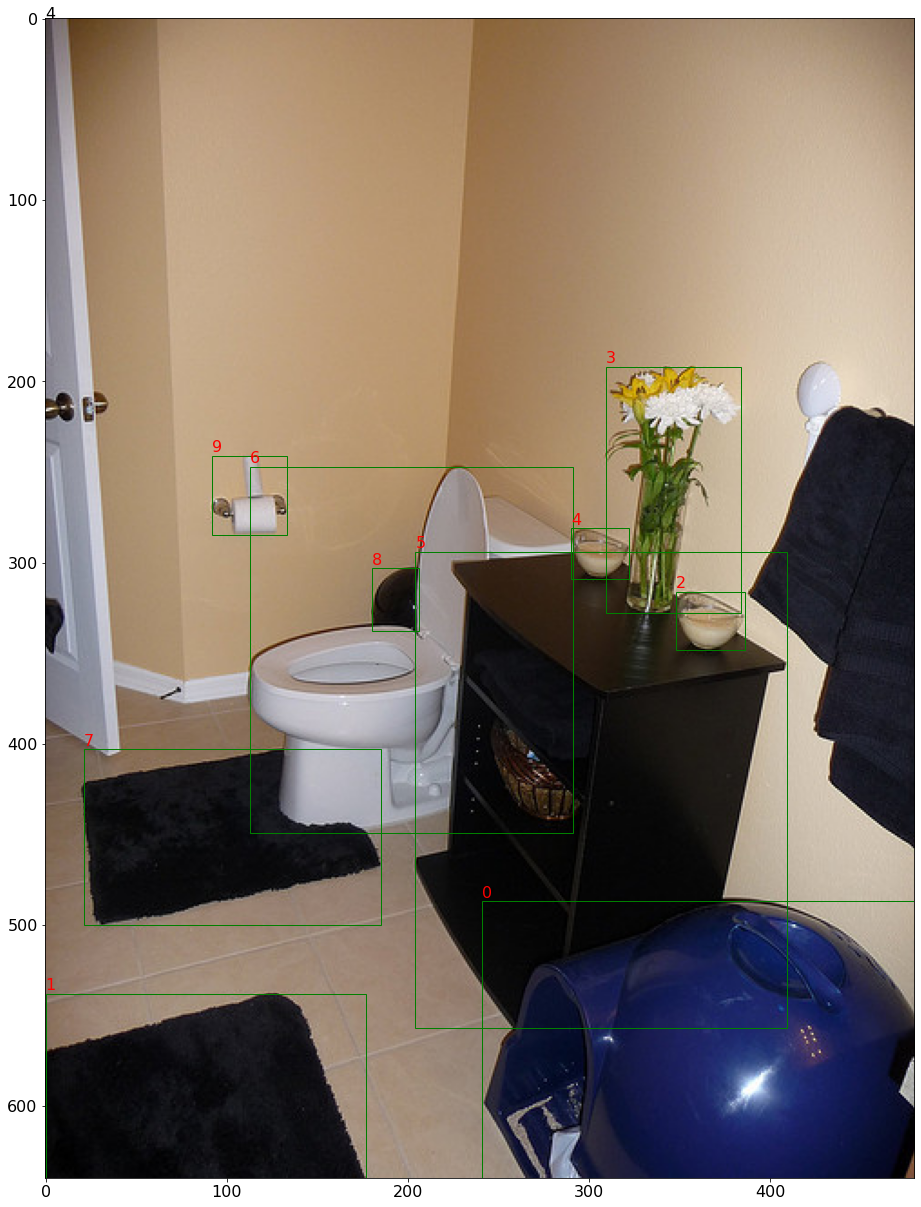

In [5]:
# read data
test_example_image = True # set to False to test any image in COCOA validation set (need to download the dataset)
if test_example_image:
    img_idx = 4 # select from {1,2,3,4,5}, background things have been removed.
    image_fn = 'demo_data/COCOA/{}.jpg'.format(img_idx)
    annot_fn = 'demo_data/COCOA/{}.json'.format(img_idx)
    img = Image.open(image_fn)
    height, width = img.height, img.width
    modal, category, ori_bboxes, amodal_gt = read_annot(annot_fn, height, width)
else: # test all images
    img_idx = 408 # select from range(1323), note that some background things may also be included.
    modal, category, ori_bboxes, amodal_gt, image_fn = data_reader.get_image_instances(
        img_idx, with_gt=True, ignore_stuff=True)
    image_fn = os.path.join(img_root, image_fn)
    img = Image.open(image_fn)
    height, width = img.height, img.width

######## do not modify below #########
image = np.array(img)
plt.figure(figsize=(16, 16./width*height))
plt.imshow(img)
plt.text(0, 0, str(img_idx))
ax = plt.gca()
for i, bbox in enumerate(ori_bboxes):
    rect = patches.Rectangle(bbox[:2], bbox[2], bbox[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1]-2, str(i), color='r')
plt.show()

In [6]:
gt_order_matrix = infer.infer_gt_order(modal, amodal_gt)

In [7]:
print(gt_order_matrix.shape)

(10, 10)


In [8]:
print(modal.shape)
print(modal[0].shape)
print(image.shape)

(10, 640, 480)
(640, 480)
(640, 480, 3)


In [9]:
mask = np.zeros(modal[0].shape)

for i in range(1, modal.shape[0] + 1):
    mask += i * (modal[i-1] > 0)

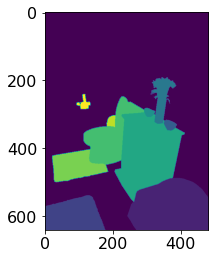

In [10]:
plt.imshow(mask)

In [11]:
print(np.amax(mask))

10.0


In [13]:
def neighbors(r, c, R, C):
    lst = []
    if c + 1 < C:
        lst.append((r, c+1))
    else:
        lst.append(None)
    if r + 1 < R:
        if c - 1 > 0:
            lst.append((r+1, c-1))
        else:
            lst.append(None)
        lst.append((r+1, c))
        if c + 1 < C:
            lst.append((r+1, c+1))
        else:
            lst.append(None)
    else:
        lst.extend([None, None, None])
    return lst

In [14]:
# maps r, c of a pixel to an id
# id = C * r + c
# dict[id1][id2] = 1 if id1 is above id2, else -1

# 4 channel rep is better
results = np.zeros((image.shape[0], image.shape[1], 4))

R, C = image.shape[0], image.shape[1]

for r in range(image.shape[0]):
    for c in range(image.shape[1]):
        if mask[r][c] == 0:
            continue
        for i in range(1, modal.shape[0] + 1):
            if mask[r][c] == i:
                pairs = neighbors(r, c, R, C)
                for k in range(4):
                    pair = pairs[k]
                    if pair is None:
                        results[r][c][k] = 0
                        continue
                    j = int(mask[pair[0]][pair[1]])
                    results[r][c][k] = gt_order_matrix[i-1][j-1]

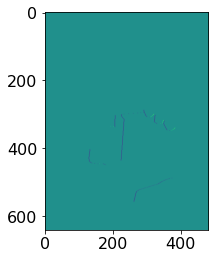

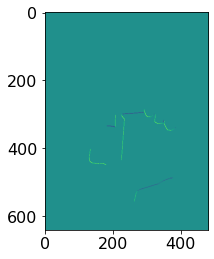

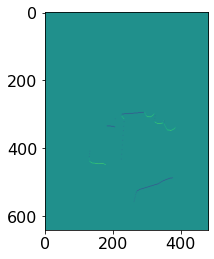

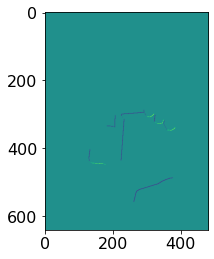

In [15]:
for i in range(4):
    plt.imshow(results[:,:,i])
    plt.show()

In [16]:
import time 

start_time = time.time()

for img_idx in range(1242, 1323):
    if img_idx % 100 == 0:
        print(img_idx)
        print(str(time.time() - start_time) + 'seconds have elapsed') 
    
    modal, category, ori_bboxes, amodal_gt, image_fn = data_reader.get_image_instances(
        img_idx, with_gt=True, ignore_stuff=True)
    image_fn = os.path.join(img_root, image_fn)
    img = Image.open(image_fn)
    height, width = img.height, img.width
    image = np.array(img)
    
    if modal.size == 0:
        continue 
    
    mask = np.zeros(modal[0].shape)
#     print(mask.shape)
#     print(image.shape)

    for i in range(1, modal.shape[0] + 1):
        mask += i * (modal[i-1] > 0)
    
    gt_order_matrix = infer.infer_gt_order(modal, amodal_gt)
    
    results = np.zeros((image.shape[0], image.shape[1], 4))

    R, C = image.shape[0], image.shape[1]

    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if mask[r][c] == 0:
                continue
            for i in range(1, modal.shape[0] + 1):
                if mask[r][c] == i:
                    pairs = neighbors(r, c, R, C)
                    for k in range(4):
                        pair = pairs[k]
                        if pair is None:
                            results[r][c][k] = 0
                            continue
                        j = int(mask[pair[0]][pair[1]])
#                         if r == 5 or c == 5:
#                             print('r:', r, 'c:', c, 'k:', k)
#                             print('i:', i, 'j:', j)
#                             print(gt_order_matrix.shape)
                        results[r][c][k] = gt_order_matrix[i-1][j-1]
                        
    path = "../data/COCOA/pixel_graphs/" + str(img_idx) + '.txt'
    tensor = torch.tensor(results)
    torch.save(tensor, path)

1300
103.75916695594788seconds have elapsed
